# Part B. 재구매 유형 예측모델 개발

# 0. Import library

In [20]:
# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVC

# Regression
import xgboost
from math import sqrt
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor

# 1. Data Pre-Processing

### 1) 대차/추가구매 DataFrame 병합

In [22]:
# 대차/추가구매 데이터프레임 병합
# 고객정보
고객정보 = pd.concat([대차_고객정보, 추가구매_고객정보])
고객정보 = 고객정보[['고객ID', '개인사업자여부', '주택 평균가격', '성별', '대차/추가구매 소요기간', '출고_보유종료', '대차/추가구매', '|대차/추가구매|', 'label']]

# 접촉정보
대차_접촉정보 = 대차_접촉정보[['고객ID', '접촉채널명', '접촉업무명']]
추가구매_접촉정보 = 추가구매_접촉정보[['고객ID', '접촉채널명', '접촉업무명']]
접촉정보 = pd.concat([대차_접촉정보, 추가구매_접촉정보])
접촉건수 = 접촉정보.groupby('고객ID').count().reset_index()
접촉건수.rename(columns={'접촉채널명':'접촉건수'}, inplace=True)
접촉건수 = 접촉건수[['고객ID', '접촉건수']]

# 차량정보
대차_차량 = 대차_차량[['고객ID', '차명', '차량등급명1', '차량등급명2', '엔진타입명', '트림명']]
추가구매_차량 = 추가구매_차량[['고객ID', '차명', '차량등급명1', '차량등급명2', '엔진타입명', '트림명']]
차량정보 = pd.concat([대차_차량, 추가구매_차량])

**접촉정보** DataFrame의 경우, 고객ID별 접촉건수를 파악하여 분석에 활용하는 것이 유의미할 것이라고 판단하여 **접촉건수** column을 생성했습니다.

### 2) 예측모델을 위한 DataFrame 생성

In [24]:
merge_data = pd.merge(고객정보, 접촉건수, on='고객ID', how='inner')

**차량정보** 데이터의 경우, 모든 column이 **범주형**이며 차명, 차량등급명, 트림명 등 많은 경우의 수를 가진 DataFrame이기 때문에 예측모델을 학습시키기에 적합하지 않다고 판단되어 배제하였습니다. 따라서 **고객ID**를 기준으로 고객정보와 접촉건수 DataFrame을 병합하였습니다.

In [25]:
print("주택 평균가격 null 갯수 :", merge_data['주택 평균가격'].isnull().sum())
print("전체 데이터 갯수 :", len(merge_data))
print("null 비율 :", merge_data['주택 평균가격'].isnull().sum()/len(merge_data))

주택 평균가격 null 갯수 : 216032
전체 데이터 갯수 : 493812
null 비율 : 0.43747823058167884


**주택 평균가격** column의 경우, 데이터의 43%가량이 null값이기 때문에 분석에서 제외하였습니다.

In [26]:
# 최종 데이터프레임 생성
col = ['개인사업자여부', '성별', '대차/추가구매 소요기간', '출고_보유종료', '대차/추가구매', '|대차/추가구매|', '접촉건수']
input_data = merge_data[col]

# Categorical 변수 One-Hot Encoding
input_data = pd.get_dummies(input_data , columns=['개인사업자여부', '성별'])

분석에 활용할 최종 DataFrame을 생성하고, 범주형 변수(개인사업자여부, 성별)는 **one-hot-encoding**을 통해 분석에 적합한 형태로 만들었습니다.

### 3) 독립변수 / 종속변수 분리 & 학습데이터 / 검증데이터 분리

In [27]:
# 독립변수(x_data) / 종속변수(y_data) 분리
x_data = input_data
y_data = merge_data[['label']]

# 학습데이터(train) / 검증데이터(test) 분리 - 7:3
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=777, stratify=y_data)

**독립변수**는 label을 제외한 모든 변수이고, **종속변수**는 고객별 label값 입니다.<br>
분리한 독립변수, 종속변수 DataFrame을 **7:3** 비율로 학습데이터와 검증데이터로 분리했습니다.

# 2. 이진분류 예측모델 생성

예측모델은 고객별 대차/추가구매 가능성을 **이진분류** 하는 것을 목표로 하기 때문에 지도학습 분류(Classification) 알고리즘을 사용했습니다. Classification은 Supervised learning 지도학습의 일종으로 기존에 존재하는 데이터의 Category 관계를 파악하고, 새롭게 관측된 데이터의 Category를 스스로 판별하는 과정입니다. <br><br> 과제1에서 정답(label)이 없는 데이터셋을 비지도학습 Clustering 방식으로 분류했다면, 지금은 정답(label)이 있는 데이터이기 때문에 지도학습 기계학습 알고리즘을 사용하는 것이 적합하다고 판단하였습니다. <br><br> 예측모델은 여러 알고리즘을 같은 훈련 & 검증 데이터로 학습시키고 검증하여 **accuracy_score, precision_score, recall_score, f1_score**가 가장 높은 모델을 선정하는 방식으로 진행했습니다.

>* **랜덤포레스트**<br>
분류, 회귀 분석 등에 사용되는 앙상블 학습 방법의 일종으로, 훈련 과정에서 구성한 다수의 결정 트리로부터 부류(분류) 또는 평균 예측치(회귀 분석)를 출력함으로써 동작하는 알고리즘입니다.

>* **서포트벡터머신**<br>
결정 경계(Decision Boundary), 즉 분류를 위한 기준 선을 정의하는 알고리즘입니다. 따라서 분류되지 않은 새로운 점이 나타나면 경계의 어느 쪽에 속하는지 확인해서 분류 과제를 수행할 수 있게 됩니다.

>* **나이브베이즈**<br>
베이즈 이론(Bayes theorem)의 확률 모델을 기반으로 하는 강력한 분류기 알고리즘입니다. 기본적으로 각 속성값 확률을 기반으로 범주에 속한 인스턴스를 확률을 이용하여 분류합니다.

>* **KNN**<br>
데이터를 분류하고 새로운 데이터 포인트의 카테고리를 결정할 때 K개의 가장 가까운 포인트를 선점하고 그중 가장 많이 선택된 포인트의 카테고리로 이 새로운 데이터를 분류하는 알고리즘입니다.

>* **로지스틱회귀**<br>
회귀를 사용하여 데이터가 어떤 범주에 속할 확률을 0에서 1 사이의 값으로 예측하고 그 확률에 따라 가능성이 더 높은 범주에 속하는 것으로 분류해주는 지도 학습 알고리즘입니다.

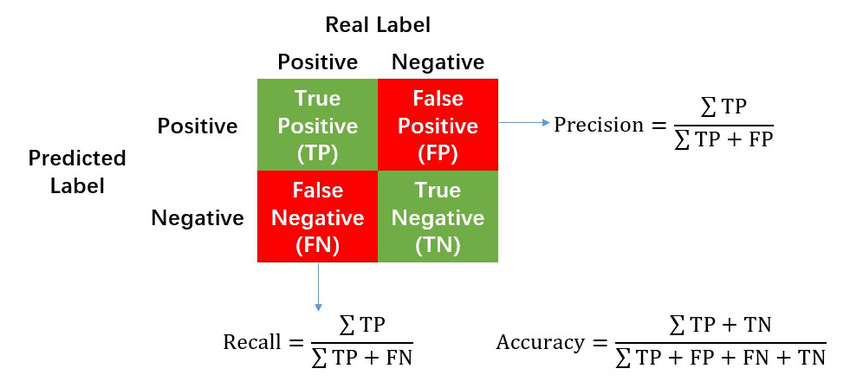

In [28]:
Image('정확도.png')

분류 알고리즘의 성능평가 지표로는 **정확도, 정밀도, 재현율, f1_score(정밀도와 재현율의 조화평균)** 을 이용했습니다. 알고리즘별 성능평가 지표를 비교한 후 지표들 가운데 가장 높은 값을 가지고 있는 모델을 선정했습니다. 

### 1) 분류 알고리즘 실행 및 검증

In [29]:
# RandomForest
model = RandomForestClassifier()
model.fit(X=X_train, y=y_train)

y_pred = model.predict(X = X_test)
y_true = y_test

rf_acc = accuracy_score(y_true, y_pred)
rf_pre = precision_score(y_true, y_pred)
rf_recall = recall_score(y_true, y_pred)
rf_f1 = f1_score(y_true, y_pred)


# 서포트벡터머신
model = SVC()
model.fit(X=X_train, y=y_train)

y_pred = model.predict(X_test)
y_true = y_test

svc_acc = accuracy_score(y_true, y_pred)
svc_pre = precision_score(y_true, y_pred)
svc_recall = recall_score(y_true, y_pred)
svc_f1 = f1_score(y_true, y_pred)


# 나이브베이즈
model = GaussianNB()
model.fit(X=X_train, y=y_train)

y_pred = model.predict(X_test)
y_true = y_test

nb_acc = accuracy_score(y_true, y_pred)
nb_pre = precision_score(y_true, y_pred)
nb_recall = recall_score(y_true, y_pred)
nb_f1 = f1_score(y_true, y_pred)


# KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_true = y_test

knn_acc = accuracy_score(y_true, y_pred)
knn_pre = precision_score(y_true, y_pred)
knn_recall = recall_score(y_true, y_pred)
knn_f1 = f1_score(y_true, y_pred)


# LogisticRegression
log = LogisticRegression()
log.fit(X_train, y_train)

y_pred = log.predict(X_test)
y_true = y_test

LR_acc = accuracy_score(y_true, y_pred)
LR_pre = precision_score(y_true, y_pred)
LR_recall = recall_score(y_true, y_pred)
LR_f1 = f1_score(y_true, y_pred)

### 2) Confusion Matrix (혼동행렬)

In [30]:
confusion_matrix(y_true, y_pred)

array([[81112,   434],
       [  314, 66284]])

### 3) 알고리즘별 성능평가 지표 시각화

In [31]:
# 모델별 accuracy_score 점수 DataFrame 생성
accuracy = pd.DataFrame([rf_acc, svc_acc, nb_acc, knn_acc, LR_acc], columns=['accuracy'], index=['랜덤포레스트', '서포트벡터머신', '나이브베이즈', 'KNN', '로지스틱회귀'])
accuracy.sort_values(by=['accuracy'], axis=0, ascending=False, inplace=True)

# 모델별 accuracy_score 시각화
colors = ['lightslategray',] * 5
colors[0] = 'crimson'

fig = go.Figure(go.Bar(x=accuracy.index, y=accuracy['accuracy'], marker_color=colors))
fig.update_layout(title_text='Accuracy Score')

In [32]:
# 모델별 precision_score 점수 DataFrame 생성
precision = pd.DataFrame([rf_pre, svc_pre, nb_pre, knn_pre, LR_pre], columns=['precision'], index=['랜덤포레스트', '서포트벡터머신', '나이브베이즈', 'KNN', '로지스틱회귀'])
precision.sort_values(by=['precision'], axis=0, ascending=False, inplace=True)

# 모델별 precision_score 시각화
colors = ['lightslategray',] * 5
colors[0] = 'crimson'

fig = go.Figure(go.Bar(x=precision.index, y=precision['precision'], marker_color=colors))
fig.update_layout(title_text='Precision Score')

In [33]:
# 모델별 recall_score 점수 DataFrame 생성
recall = pd.DataFrame([rf_recall, svc_recall, nb_recall, knn_recall, LR_recall], columns=['recall'], index=['랜덤포레스트', '서포트벡터머신', '나이브베이즈', 'KNN', '로지스틱회귀'])
recall.sort_values(by=['recall'], axis=0, ascending=False, inplace=True)

# 모델별 recall_score 시각화
colors = ['lightslategray',] * 5
colors[0] = 'crimson'

fig = go.Figure(go.Bar(x=recall.index, y=recall['recall'], marker_color=colors))
fig.update_layout(title_text='Recall Score')

In [34]:
# 모델별 fl_score 점수 DataFrame 생성
fl_score = pd.DataFrame([rf_f1, svc_f1, nb_f1, knn_f1, LR_f1], columns=['fl_score'], index=['랜덤포레스트', '서포트벡터머신', '나이브베이즈', 'KNN', '로지스틱회귀'])
fl_score.sort_values(by=['fl_score'], axis=0, ascending=False, inplace=True)

# 모델별 fl_score 시각화
colors = ['lightslategray',] * 5
colors[0] = 'crimson'

fig = go.Figure(go.Bar(x=fl_score.index, y=fl_score['fl_score'], marker_color=colors))
fig.update_layout(title_text='F1 Score')

위 결과를 바탕으로 성능지표 모두에서 1위를 한 **서포트벡터머신(SVM)** 을 최종 예측모델로 선정하였습니다.

# 3. 변수중요도 확인

나아가, label 값에 어떠한 변수들이 얼만큼의 영향을 미쳤는가를 파악하기 위해 **회귀분석 알고리즘**을 실행했습니다. 독립변수는 label을 제외한 모든 변수이며 종속변수는 label 값입니다.<br><br>
사용한 알고리즘은 그래디언트 부스팅에 해당하는 **XGBoost, LightGBM, CatBoost** 입니다. 그래디언트 부스팅은 회귀 및 분류 문제에 대한 기계 학습 기술로, 약한 예측 모델, 일반적으로 의사 결정 트리의 앙상블 형태로 예측 모델을 생성합니다. 다른 부스팅 방법과 마찬가지로 단계적으로 모델을 빌드하고 임의의 차별화 가능한 손실 함수를 최적화하여 모델을 일반화합니다.

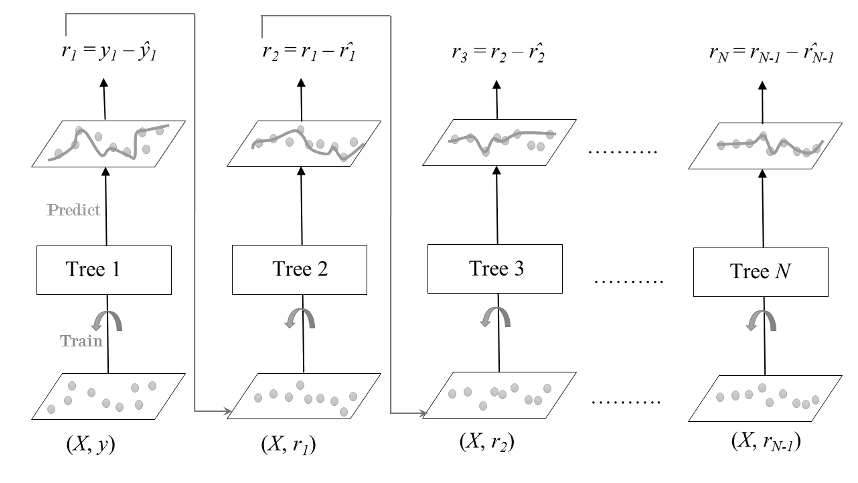

In [35]:
Image('그래디언트.png')

### 1) 회귀분석 알고리즘 선정

각 알고리즘의 **RMSE(평균 제곱근 오차)**를 비교하여 RMSE가 가장 낮은 모델을 선정하여 변수중요도를 파악하였습니다.

In [36]:
# XGBRegressor
liner_model = xgboost.XGBRegressor() 
liner_model.fit(X_train, y_train)
liner_model_predict = liner_model.predict(X_test)
XGBRegressor_RMSE = sqrt(mean_squared_error(liner_model_predict, y_test))

# lightgbm
lgb_dtrain = lgb.Dataset(data = X_train, label = y_train)
lgb_param = {'max_depth': 10,
            'learning_rate': 0.01,
            'n_estimators': 1000,
            'objective': 'regression'}
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain)
lgb_model_predict = lgb_model.predict(X_test)
lightgbm_RMSE = sqrt(mean_squared_error(lgb_model_predict, y_test))

# CatBoostRegressor
cb_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=4, l2_leaf_reg=20, bootstrap_type='Bernoulli', subsample=0.6, eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False) 
cb_model.fit(X_train, y_train) 
cb_model_predict = cb_model.predict(X_test)
CatBoostRegressor_RMSE = sqrt(mean_squared_error(cb_model_predict, y_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 345668, number of used features: 9
[LightGBM] [Info] Start training from score 0.449547
0:	learn: 0.4510388	total: 74.4ms	remaining: 1m 14s
50:	learn: 0.0733651	total: 684ms	remaining: 12.7s
100:	learn: 0.0623786	total: 1.31s	remaining: 11.7s
150:	learn: 0.0570042	total: 1.84s	remaining: 10.3s
200:	learn: 0.0534258	total: 2.37s	remaining

In [37]:
# 모델별 RMSE DataFrame 생성
RMSE = pd.DataFrame([XGBRegressor_RMSE, lightgbm_RMSE, CatBoostRegressor_RMSE], columns=['RMSE'], index=['XGBRegressor', 'lightgbm', 'CatBoostRegressor'])
RMSE.sort_values(by=['RMSE'], axis=0, ascending=False, inplace=True)

# 모델별 RMSE 시각화
colors = ['lightslategray',] * 5
colors[2] = 'crimson'

fig = go.Figure(go.Bar(x=RMSE.index, y=RMSE['RMSE'], marker_color=colors))
fig.update_layout(title_text='RMSE')

분석 결과, **XGBRegressor**의 RMSE가 가장 낮기 때문에 해당 알고리즘을 사용하여 변수의 영향도를 파악했습니다.

### 2. SHAP 시각화

변수의 중요도를 파악하기 위해 **SHAP**를 활용하여 시각화하였습니다. SHAP(SHAPley Additional exPlanations)는 개별 예측을 설명합니다. SHAP는 최적의 shapely 값을 이론적으로 한 게임을 기반으로 하여 기계학습을 해석하고 설명할 수 있도록 만들어진 방식입니다.

In [38]:
import shap
explainer = shap.TreeExplainer(liner_model)
shap_values = explainer.shap_values(X_test)

XGBRegressor model을 shap tree model에 지정한 후 Shap values를 계산합니다.

* **SHAP Summary Plot**

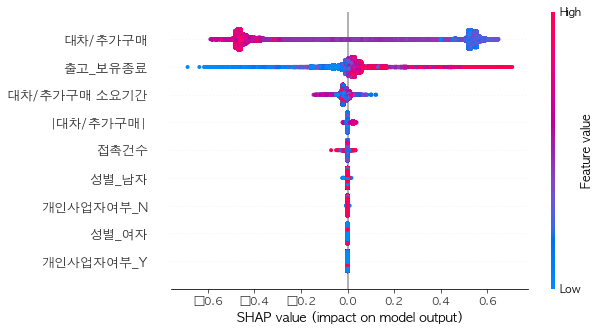

In [40]:
plt.rcParams['font.family'] = 'AppleGothic'
shap.summary_plot(shap_values, X_test)

이 그래프는 모든 변수들의 shap value를 요약한 것입니다. 해당 변수가 **빨간색**을 띄면 target에 대해 **양의 영향력**이 존재하는 것이고, **파란색**을 띄면 **음의 영향**이 존재하는 것입니다.

> **대차/추가구매** : 값이 높을 수록 1에 가까운 경향이 있다. (대차에 가까워진다.)<br>
> **출고_보유종료** : 값이 높을 수록 0에 가까운 경향이 있다. (추가구매에 가까워진다.)

*(나머지 변수는 특이점 없음)*

* **SHAP Feature Importance**

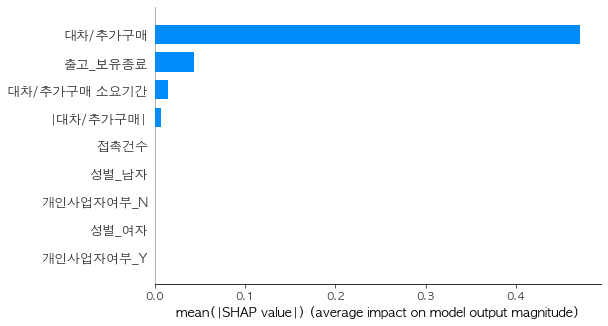

In [41]:
# 각 변수에 대한 |Shap Values|을 통해 변수 importance 파악
plt.rcParams['font.family'] = 'AppleGothic'
shap.summary_plot(shap_values, X_test, plot_type = "bar")

이 그래프는 각 변수의 shap value에 절댓값을 취한 것으로 **변수의 평균적인 영향력**을 보여줍니다. 큰 영향력을 보일 수록 target과의 관계성이 크다는 것을 뜻합니다. (변수 중요도와 비슷한 개념)<br>

> **대차/추가구매** > **출고_보유종료** > **대차/추가구매 소요기간** 순으로 영향력이 큰 것을 알 수 있다.

* **SHAP Dependency Plot**

아래 그래프들은 **변수간 의존성**을 보여주는 shap value 입니다.

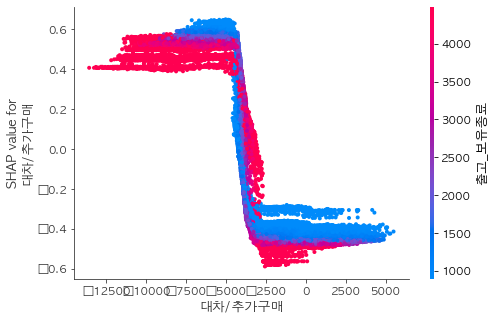

In [42]:
# 대차/추가구매
plt.rcParams['font.family'] = 'AppleGothic'
shap.dependence_plot("대차/추가구매", shap_values, X_test)

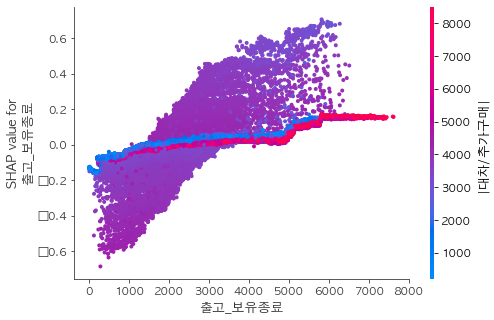

In [43]:
# 출고_보유종료
plt.rcParams['font.family'] = 'AppleGothic'
shap.dependence_plot("출고_보유종료", shap_values, X_test)

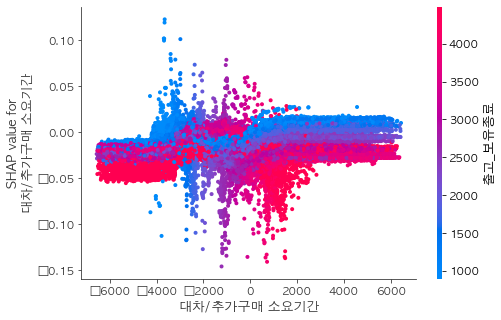

In [44]:
# 대차/추가구매 소요기간
plt.rcParams['font.family'] = 'AppleGothic'
shap.dependence_plot("대차/추가구매 소요기간", shap_values, X_test)

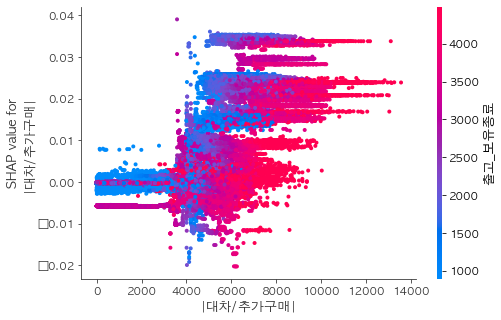

In [45]:
# |대차/추가구매|
plt.rcParams['font.family'] = 'AppleGothic'
shap.dependence_plot("|대차/추가구매|", shap_values, X_test)

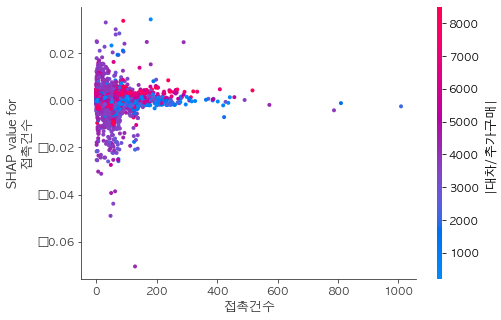

In [46]:
# 접촉건수
plt.rcParams['font.family'] = 'AppleGothic'
shap.dependence_plot("접촉건수", shap_values, X_test)